<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone: Pixel Pilot, Object Detection for Self Driving Car
# Initial Model Exploration

> Authors: Michael King Sutanto

This Jupyter Notebook functions as an annex, documenting initial exploration with YOLOv8. An attempt was made to augment the YOLOv8 architecture by incorporating an additional head exclusively for new classes, with the intention of training solely on these classes. This endeavor necessitated modifications to configuration and engine files. However, despite these efforts, the outcome was unsuccessful. The revised model failed to retain knowledge of previously learned classes and solely recognized the newly introduced classes.

#### Update 20/5/2024: We successfully added an extra head specifically for the new class (**traffic cone**) and trained the new head.

In [1]:
# Reset runtime
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
!nvidia-smi

Sun May 19 15:02:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Set HOME dir
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Install Ultralytic & Roboflow

In [4]:
!git clone https://github.com/ultralytics/ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 26154, done.
remote: Counting objects: 100% (810/810), done.
remote: Compressing objects: 100% (448/448), done.
remote: Total 26154 (delta 464), reused 632 (delta 359), pack-reused 25344
Receiving objects: 100% (26154/26154), 15.56 MiB | 13.36 MiB/s, done.
Resolving deltas: 100% (18428/18428), done.


In [5]:
%cd {HOME}
%cd ultralytics

/content
/content/ultralytics


In [6]:
# Lock at ultralytics v8.1.23
!git reset --hard 2071776a3672eb835d7c56cfff22114707765ac

HEAD is now at 2071776a `ultralytics 8.1.23` add YOLOv9-C and E models (#8571)


In [7]:
!pip install -e .

Obtaining file:///content/ultralytics
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-many

In [8]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.1

In [9]:
from ultralytics import YOLO
import torch
import copy

# 2. Import Dataset from Roboflow

In [10]:
# Traffic cones dataset is from roboflow: https://universe.roboflow.com/robotica-xftin/traffic-cones-4laxg/dataset/2

from roboflow import Roboflow
rf = Roboflow(api_key="Insert API key")
project = rf.workspace("robotica-xftin").project("traffic-cones-4laxg")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.23, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Traffic-Cones-2 in yolov8:: 100%|██████████| 3120/3120 [00:00<00:00, 8424.02it/s]


In [11]:
%cd {dataset.location}
%ls

/content/ultralytics/Traffic-Cones-2
data.yaml  README.dataset.txt  README.roboflow.txt  test/  train/  valid/


In [12]:
# Move data.yaml under datasets
!mkdir -p /content/datasets/Traffic-Cones-2
!mv * /content/datasets/Traffic-Cones-2
!mv /content/datasets/Traffic-Cones-2/data.yaml /content/datasets

# 3. Train A Model With Frozen COCO Backbone

In [13]:
# Reset runtime
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

# Wait for restart and then continue

{'status': 'ok', 'restart': True}

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

In [2]:
%cd {HOME}
%cd ultralytics

/content
/content/ultralytics


In [3]:
# Download patch for adding head architecture
!wget https://gist.githubusercontent.com/Y-T-G/8f4fc0b78a0a559a06fe84ae4f359e6e/raw/17b1407fefeac86d089c4cf14f174c8bb44948af/add_head.patch

--2024-05-19 15:07:10--  https://gist.githubusercontent.com/Y-T-G/8f4fc0b78a0a559a06fe84ae4f359e6e/raw/17b1407fefeac86d089c4cf14f174c8bb44948af/add_head.patch
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10458 (10K) [text/plain]
Saving to: ‘add_head.patch’

add_head.patch      100%[===================>]  10.21K  --.-KB/s    in 0.001s  

2024-05-19 15:07:10 (10.1 MB/s) - ‘add_head.patch’ saved [10458/10458]



In [4]:
!git apply add_head.patch

In [5]:
from ultralytics import YOLO
import torch
import copy

In [6]:
model = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 21.3MB/s]


In [7]:
# Keep a copy of old state dict for sanity check
old_dict = copy.deepcopy(model.state_dict())

In [8]:
# We should freeze all but the last layer
model.state_dict().keys()

odict_keys(['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.0.bn.num_batches_tracked', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv1.bn.num_batches_tracked', 'model.model.2.cv2.conv.weight', 'model.model.2.cv2.bn.weight', 'model.model.2.cv2.bn.bias', 'model.model.2.cv2.bn.running_mean', 'model.model.2.cv2.bn.running_var', 'model.model.2.cv2.bn.num_batches_tracked', 'model.model.2.m.0.cv1.conv.weight', 'model.model.2.m.0.cv1.bn.weight', 'model.model.2.m.0.cv1.bn.bias', 'model.model.2.m.0.cv1.bn.running_mean', 'model.model.2.m.0.cv1.bn.running_var', 'model.mod

In [9]:
# Add a callback to put the frozen layers in eval mode to prevent BN values
# from changing.
def put_in_eval_mode(trainer, n_layers=22):
  for i, (name, module) in enumerate(trainer.model.named_modules()):
    if name.endswith("bn") and int(name.split('.')[1]) < n_layers:
      module.eval()
      module.track_running_stats = False
      # print(name, " put in eval mode.")

In [10]:
model.add_callback("on_train_epoch_start", put_in_eval_mode)
model.add_callback("on_pretrain_routine_start", put_in_eval_mode)

### Freeze The First 22 layers [0-21] and Only Train New Data (Traffic Cones)

In [11]:
# Train the model.
results = model.train(data='/content/datasets/data.yaml', freeze=22, epochs=100, imgsz=640)

New https://pypi.org/project/ultralytics/8.2.18 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.23 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/datasets/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=22, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

100%|██████████| 755k/755k [00:00<00:00, 4.04MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/datasets/Traffic-Cones-2/train/labels... 1362 images, 9 backgrounds, 0 corrupt: 100%|██████████| 1362/1362 [00:00<00:00, 1386.75it/s]


train: New cache created: /content/datasets/Traffic-Cones-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/Traffic-Cones-2/valid/labels... 124 images, 2 backgrounds, 0 corrupt: 100%|██████████| 124/124 [00:00<00:00, 1715.33it/s]

val: New cache created: /content/datasets/Traffic-Cones-2/valid/labels.cache


Plotting labels to /content/ultralytics/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/ultralytics/runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.04G      1.532      2.247      1.834         15        640: 100%|██████████| 86/86 [00:10<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        124        202      0.779      0.525      0.592      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.898G      1.455       1.94      1.785          3        640: 100%|██████████| 86/86 [00:07<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]

                   all        124        202        0.7      0.678       0.72      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.898G      1.451      1.759      1.769          3        640: 100%|██████████| 86/86 [00:07<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.93it/s]

                   all        124        202      0.676      0.661      0.681      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.898G      1.439      1.638      1.746          5        640: 100%|██████████| 86/86 [00:08<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]

                   all        124        202      0.572      0.682       0.64      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.898G      1.425      1.562      1.738          6        640: 100%|██████████| 86/86 [00:07<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.65it/s]

                   all        124        202      0.736       0.65      0.702      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.919G      1.416      1.504      1.728          8        640: 100%|██████████| 86/86 [00:07<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.01it/s]

                   all        124        202      0.774      0.649      0.718      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.898G      1.394      1.478      1.722          4        640: 100%|██████████| 86/86 [00:07<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]

                   all        124        202      0.747      0.733      0.771        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.919G      1.388      1.446      1.711         11        640: 100%|██████████| 86/86 [00:07<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

                   all        124        202      0.731      0.752      0.764      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.916G      1.391      1.458      1.719          7        640: 100%|██████████| 86/86 [00:07<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

                   all        124        202      0.801      0.733        0.8       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.923G      1.368      1.427      1.689         11        640: 100%|██████████| 86/86 [00:07<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]

                   all        124        202      0.758      0.708      0.774      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.898G       1.38      1.412        1.7          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        124        202      0.799      0.713      0.801      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.898G      1.337      1.377      1.659          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.66it/s]

                   all        124        202      0.777      0.742      0.795      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.898G      1.354      1.388      1.689          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

                   all        124        202       0.74      0.728       0.77      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.921G      1.372      1.381      1.695          4        640: 100%|██████████| 86/86 [00:07<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.84it/s]

                   all        124        202      0.773      0.708       0.75      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.898G      1.304       1.34       1.65          3        640: 100%|██████████| 86/86 [00:07<00:00, 11.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        124        202      0.764       0.69      0.757      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.898G      1.346      1.359      1.686          6        640: 100%|██████████| 86/86 [00:07<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        124        202       0.74      0.788      0.802      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.898G      1.333      1.319      1.656          7        640: 100%|██████████| 86/86 [00:07<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.63it/s]

                   all        124        202      0.738      0.768      0.763      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.895G      1.328      1.334      1.678          7        640: 100%|██████████| 86/86 [00:07<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        124        202      0.741      0.723      0.783      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.923G      1.323      1.328      1.658          6        640: 100%|██████████| 86/86 [00:07<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.71it/s]

                   all        124        202      0.751      0.747      0.789      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.898G      1.312      1.305      1.649          9        640: 100%|██████████| 86/86 [00:07<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

                   all        124        202      0.753      0.743      0.725      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.898G      1.324      1.305      1.652          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.60it/s]

                   all        124        202      0.744      0.752      0.783      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.898G        1.3      1.301       1.64          7        640: 100%|██████████| 86/86 [00:07<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]

                   all        124        202      0.745      0.713      0.764      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.898G      1.304      1.272      1.642          6        640: 100%|██████████| 86/86 [00:07<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.79it/s]

                   all        124        202      0.776      0.713      0.769      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.925G      1.306      1.276      1.645          4        640: 100%|██████████| 86/86 [00:07<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]

                   all        124        202      0.795      0.718      0.774      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.895G      1.292      1.275      1.633          9        640: 100%|██████████| 86/86 [00:07<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.17it/s]

                   all        124        202      0.837      0.728      0.809      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.895G      1.274      1.257      1.626         11        640: 100%|██████████| 86/86 [00:07<00:00, 11.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]

                   all        124        202      0.737       0.72      0.747      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.923G      1.279      1.247      1.613          6        640: 100%|██████████| 86/86 [00:07<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

                   all        124        202      0.795      0.738      0.795      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.898G      1.278      1.256      1.619          8        640: 100%|██████████| 86/86 [00:07<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.77it/s]

                   all        124        202      0.757      0.757       0.78      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.898G      1.254      1.246      1.615          6        640: 100%|██████████| 86/86 [00:07<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        124        202      0.811      0.744      0.777      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.898G      1.259      1.261      1.609          2        640: 100%|██████████| 86/86 [00:07<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]

                   all        124        202      0.785      0.741        0.8      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.921G      1.267      1.248       1.62          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.71it/s]

                   all        124        202      0.759      0.743      0.785      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.946G      1.266      1.233      1.604         12        640: 100%|██████████| 86/86 [00:07<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.05it/s]

                   all        124        202      0.784      0.733      0.784      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.898G      1.274      1.235      1.622          3        640: 100%|██████████| 86/86 [00:07<00:00, 11.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.70it/s]

                   all        124        202       0.77      0.748      0.786      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.898G      1.275      1.227      1.622          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

                   all        124        202      0.733      0.746        0.8       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.919G      1.263      1.228      1.609          8        640: 100%|██████████| 86/86 [00:07<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        124        202      0.785      0.762      0.796      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.925G      1.257      1.232      1.607          6        640: 100%|██████████| 86/86 [00:07<00:00, 11.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

                   all        124        202       0.78      0.756      0.763      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.898G      1.254      1.256      1.612          3        640: 100%|██████████| 86/86 [00:07<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.70it/s]

                   all        124        202      0.775      0.752      0.802      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.898G      1.248      1.213      1.594          4        640: 100%|██████████| 86/86 [00:07<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

                   all        124        202      0.844      0.725      0.811       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.898G       1.24      1.204      1.604          8        640: 100%|██████████| 86/86 [00:08<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]

                   all        124        202      0.791      0.733      0.801      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.898G      1.243      1.199        1.6         15        640: 100%|██████████| 86/86 [00:07<00:00, 11.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.65it/s]

                   all        124        202      0.771      0.717      0.762      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.919G      1.256      1.225      1.606          4        640: 100%|██████████| 86/86 [00:07<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        124        202      0.817      0.693      0.757      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.898G      1.245      1.232      1.607          4        640: 100%|██████████| 86/86 [00:07<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]

                   all        124        202      0.798      0.728      0.812      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.898G      1.235       1.21      1.596          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        124        202      0.784      0.738      0.789      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.898G       1.23      1.209      1.594         14        640: 100%|██████████| 86/86 [00:07<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

                   all        124        202       0.81      0.752      0.809      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.898G      1.245      1.207      1.607          8        640: 100%|██████████| 86/86 [00:07<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.66it/s]

                   all        124        202      0.809      0.756      0.796      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.898G       1.25      1.196       1.61          3        640: 100%|██████████| 86/86 [00:07<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

                   all        124        202      0.822      0.718      0.797        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.898G      1.236      1.198      1.595         11        640: 100%|██████████| 86/86 [00:07<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

                   all        124        202      0.776      0.738      0.775      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.898G      1.213      1.193      1.605          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.09it/s]

                   all        124        202      0.814      0.723      0.795      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.921G       1.22       1.16      1.573          9        640: 100%|██████████| 86/86 [00:07<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.71it/s]

                   all        124        202      0.832      0.738      0.795      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.919G      1.204      1.159      1.569          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]

                   all        124        202      0.779      0.749       0.79      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.898G       1.24      1.192      1.607         11        640: 100%|██████████| 86/86 [00:07<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

                   all        124        202       0.77      0.738      0.776       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.898G      1.229      1.193      1.591          8        640: 100%|██████████| 86/86 [00:07<00:00, 11.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]

                   all        124        202      0.744      0.746      0.752      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.898G       1.21      1.166      1.574          3        640: 100%|██████████| 86/86 [00:07<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

                   all        124        202       0.81      0.739      0.785      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.898G       1.21      1.152      1.585          4        640: 100%|██████████| 86/86 [00:07<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]

                   all        124        202      0.744      0.791       0.77      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.921G      1.214      1.168      1.592          4        640: 100%|██████████| 86/86 [00:07<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all        124        202      0.733      0.777      0.756      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.923G      1.228      1.168      1.591          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]

                   all        124        202      0.765      0.767      0.799      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.895G      1.225      1.174      1.591          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]

                   all        124        202      0.789      0.757      0.791      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.898G      1.216      1.172      1.587          2        640: 100%|██████████| 86/86 [00:07<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.70it/s]

                   all        124        202      0.767      0.772      0.803      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.898G      1.205      1.152      1.582          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]

                   all        124        202      0.749      0.782      0.776      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.898G      1.228       1.16      1.592          7        640: 100%|██████████| 86/86 [00:07<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

                   all        124        202      0.809      0.752      0.789      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.898G      1.191      1.151      1.567          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.61it/s]

                   all        124        202      0.791      0.748      0.802      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.898G      1.216      1.155      1.588         12        640: 100%|██████████| 86/86 [00:07<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

                   all        124        202      0.791      0.767      0.804      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.898G       1.22      1.155      1.588          3        640: 100%|██████████| 86/86 [00:07<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]

                   all        124        202      0.814      0.733        0.8      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.898G      1.192       1.13      1.566          6        640: 100%|██████████| 86/86 [00:07<00:00, 11.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

                   all        124        202      0.819      0.733      0.798      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.898G      1.196      1.154      1.586          9        640: 100%|██████████| 86/86 [00:07<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

                   all        124        202       0.79      0.748      0.799      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.923G      1.187      1.142      1.554          9        640: 100%|██████████| 86/86 [00:07<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]

                   all        124        202      0.798      0.728      0.765      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.898G      1.199      1.134      1.574          7        640: 100%|██████████| 86/86 [00:07<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

                   all        124        202      0.806      0.733      0.786       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.898G      1.201      1.132      1.572          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]

                   all        124        202      0.793      0.757      0.807      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.898G      1.186      1.126      1.567          3        640: 100%|██████████| 86/86 [00:07<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

                   all        124        202      0.793      0.722      0.803      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.898G      1.189      1.151      1.578          8        640: 100%|██████████| 86/86 [00:07<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.70it/s]

                   all        124        202      0.818      0.736      0.792      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.919G       1.19      1.118      1.569          4        640: 100%|██████████| 86/86 [00:07<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.07it/s]

                   all        124        202      0.781      0.728      0.782       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.895G      1.189      1.133      1.569          9        640: 100%|██████████| 86/86 [00:07<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.70it/s]

                   all        124        202      0.784      0.702      0.781      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.925G      1.178      1.125      1.567          3        640: 100%|██████████| 86/86 [00:07<00:00, 11.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

                   all        124        202      0.778      0.711      0.786      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.898G      1.182       1.12      1.573          4        640: 100%|██████████| 86/86 [00:08<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.07it/s]

                   all        124        202      0.798      0.703      0.781      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.898G      1.169      1.124      1.553         11        640: 100%|██████████| 86/86 [00:07<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.64it/s]

                   all        124        202      0.799      0.713      0.787      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.898G      1.162      1.111      1.542          7        640: 100%|██████████| 86/86 [00:07<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        124        202      0.791       0.71       0.79      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.927G      1.184      1.124      1.571          6        640: 100%|██████████| 86/86 [00:07<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]

                   all        124        202       0.78      0.752      0.803      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.898G      1.166        1.1      1.555          8        640: 100%|██████████| 86/86 [00:07<00:00, 11.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.70it/s]

                   all        124        202      0.803      0.708      0.787      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.898G      1.185      1.132      1.557         10        640: 100%|██████████| 86/86 [00:07<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

                   all        124        202      0.811      0.733      0.807      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.921G      1.162      1.086      1.544          4        640: 100%|██████████| 86/86 [00:07<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.75it/s]

                   all        124        202      0.755      0.748      0.796      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.898G       1.15      1.108      1.549          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

                   all        124        202      0.799      0.713      0.792      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.898G      1.169      1.111      1.548          1        640: 100%|██████████| 86/86 [00:07<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.62it/s]

                   all        124        202      0.765      0.738      0.777      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.898G       1.16      1.092      1.549         11        640: 100%|██████████| 86/86 [00:07<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

                   all        124        202      0.812      0.727        0.8      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.898G      1.171      1.103      1.546         11        640: 100%|██████████| 86/86 [00:07<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]

                   all        124        202      0.777      0.728      0.774      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.916G       1.15      1.099      1.542          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.75it/s]

                   all        124        202      0.798      0.745      0.799      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.916G      1.166      1.112      1.553          2        640: 100%|██████████| 86/86 [00:07<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]

                   all        124        202      0.753      0.748      0.791      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.895G       1.14      1.108      1.538         10        640: 100%|██████████| 86/86 [00:07<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]

                   all        124        202      0.804      0.752      0.803      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.898G      1.178      1.117      1.567          2        640: 100%|██████████| 86/86 [00:07<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

                   all        124        202      0.774      0.748      0.799      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.927G      1.179      1.115      1.556          4        640: 100%|██████████| 86/86 [00:07<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]

                   all        124        202      0.771      0.767       0.81      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.898G      1.162      1.106       1.55          4        640: 100%|██████████| 86/86 [00:07<00:00, 11.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

                   all        124        202      0.795      0.748      0.823       0.43


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.17G      1.076     0.8872      1.611          2        640: 100%|██████████| 86/86 [00:08<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]

                   all        124        202      0.818      0.743      0.793      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.898G      1.071     0.8605      1.628          2        640: 100%|██████████| 86/86 [00:07<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

                   all        124        202      0.787      0.762      0.811      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.898G      1.058     0.8266      1.591          5        640: 100%|██████████| 86/86 [00:07<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]

                   all        124        202      0.819      0.757      0.819      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.895G      1.046     0.8279      1.593          2        640: 100%|██████████| 86/86 [00:07<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]

                   all        124        202      0.809      0.757      0.809      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.898G      1.041     0.8262      1.592          2        640: 100%|██████████| 86/86 [00:07<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]

                   all        124        202      0.833      0.748      0.807       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.895G      1.062     0.8314      1.613          4        640: 100%|██████████| 86/86 [00:06<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.63it/s]

                   all        124        202       0.83      0.748       0.81      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.919G      1.035     0.8156      1.589          2        640: 100%|██████████| 86/86 [00:07<00:00, 11.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

                   all        124        202      0.825      0.746      0.814      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.898G      1.032     0.8135      1.574          2        640: 100%|██████████| 86/86 [00:07<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.65it/s]

                   all        124        202      0.837      0.739      0.819      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.898G      1.035     0.8087      1.596          2        640: 100%|██████████| 86/86 [00:07<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

                   all        124        202      0.859      0.752      0.822      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.898G      1.034     0.8147       1.58          3        640: 100%|██████████| 86/86 [00:07<00:00, 11.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.62it/s]

                   all        124        202      0.817       0.75      0.822      0.424



100 epochs completed in 0.240 hours.
Optimizer stripped from /content/ultralytics/runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from /content/ultralytics/runs/detect/train/weights/best.pt, 6.3MB

Validating /content/ultralytics/runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.23 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


                   all        124        202      0.842      0.743      0.818      0.432
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to /content/ultralytics/runs/detect/train


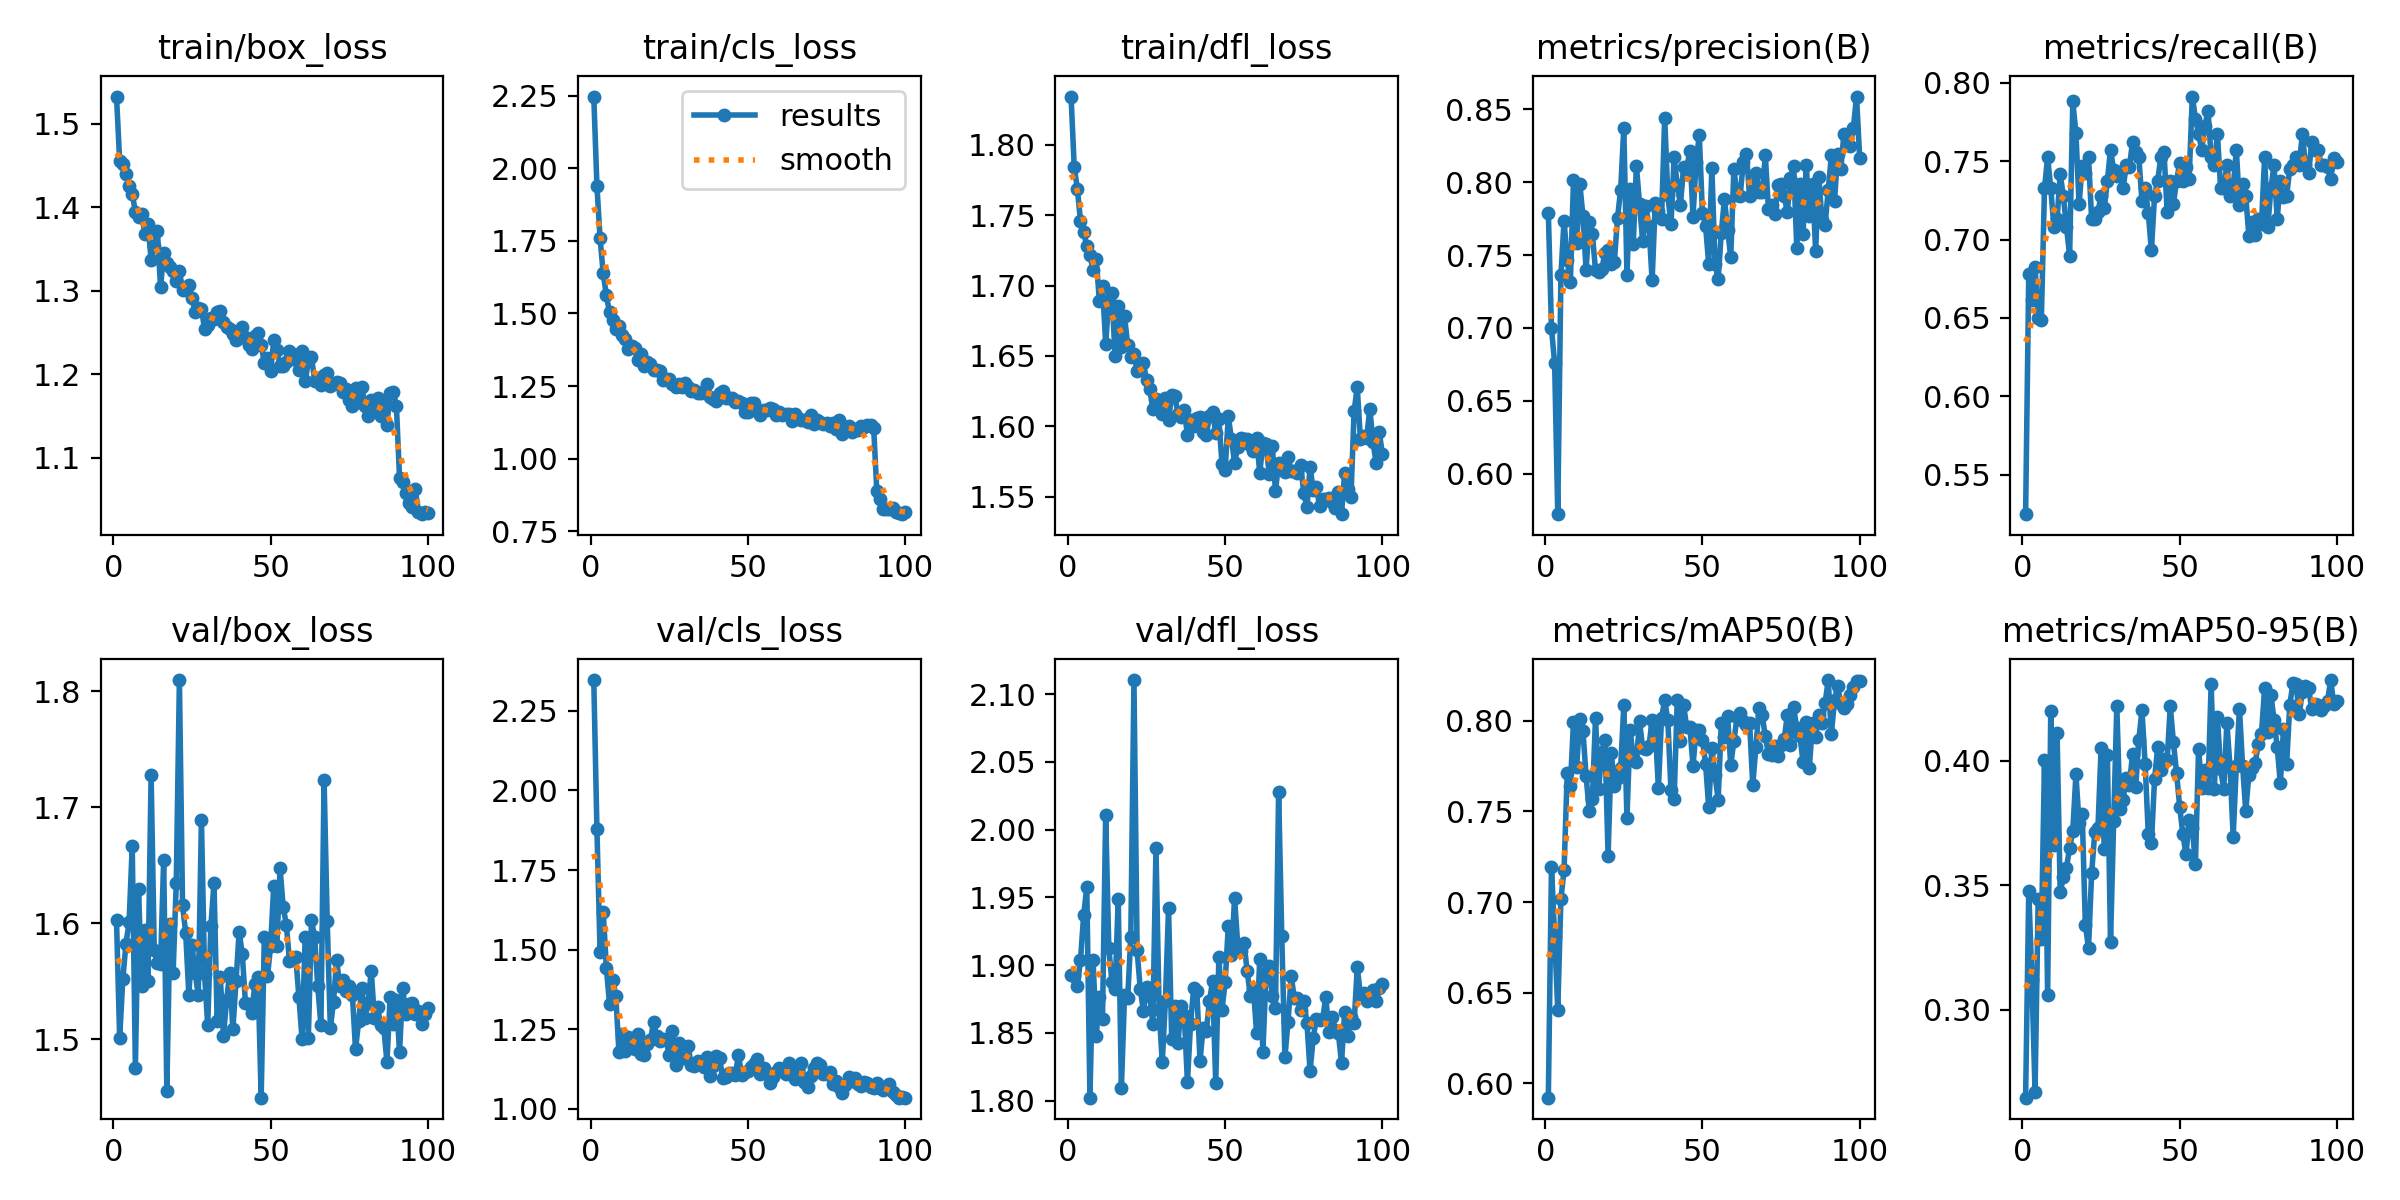

In [12]:
from IPython.display import Image
Image(filename=f'{HOME}/ultralytics/runs/detect/train/results.png', width=800)

In [16]:
def compare_dicts(state_dict1, state_dict2):
    # Compare the keys
    keys1 = set(state_dict1.keys())
    keys2 = set(state_dict2.keys())

    if keys1 != keys2:
        print("Models have different parameter names.")
        return False

    # Compare the values (weights)
    for key in keys1:
        if not torch.equal(state_dict1[key], state_dict2[key]):
            print(f"Weights for parameter '{key}' are different.")
            if "bn" in key and "22" not in key:
              state_dict1[key] = state_dict2[key]

In [17]:
compare_dicts(old_dict, model.state_dict())

Weights for parameter 'model.model.22.cv2.0.1.conv.weight' are different.
Weights for parameter 'model.model.22.cv3.2.1.bn.running_mean' are different.
Weights for parameter 'model.model.22.cv3.0.0.bn.weight' are different.
Weights for parameter 'model.model.22.cv2.0.0.bn.running_var' are different.
Weights for parameter 'model.model.22.cv2.1.0.bn.weight' are different.
Weights for parameter 'model.model.22.cv3.2.1.bn.bias' are different.
Weights for parameter 'model.model.22.cv3.1.1.conv.weight' are different.
Weights for parameter 'model.model.22.cv3.0.1.conv.weight' are different.
Weights for parameter 'model.model.22.cv2.0.1.bn.running_mean' are different.
Weights for parameter 'model.model.22.cv3.1.0.conv.weight' are different.
Weights for parameter 'model.model.22.cv3.0.1.bn.bias' are different.
Weights for parameter 'model.model.22.cv3.2.0.bn.running_mean' are different.
Weights for parameter 'model.model.22.cv2.0.2.weight' are different.
Weights for parameter 'model.model.22.cv

In [18]:
new_state_dict = dict()

In [19]:
#  Increment the head number by 1 in the state_dict
for k, v in model.state_dict().items():
  if k.startswith("model.model.22"):
    new_state_dict[k.replace("model.22", "model.23")] = v
  # else:
  #   new_state_dict[k] = v

In [20]:
# Save the current state_dict
torch.save(new_state_dict, "yolov8n_cone.pth")

In [14]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [21]:
%ls

add_head.patch   docs/       pyproject.toml   tests/                 yolov8n_cone.pth
CITATION.cff     examples/   README.md        Traffic-Cones-2/       yolov8n.pt
CONTRIBUTING.md  LICENSE     README.zh-CN.md  ultralytics/
docker/          mkdocs.yml  runs/            ultralytics.egg-info/


# Create New Architecture With Extra Head And Load Custom Weights

In [22]:
from ultralytics import YOLO
import torch

In [23]:
%cd {HOME}
%cd ultralytics/ultralytics/cfg/models/v8
!ls

/content
/content/ultralytics/ultralytics/cfg/models/v8
yolov8-cls-resnet101.yaml  yolov8-ghost.yaml	yolov8-pose-p6.yaml  yolov8-worldv2.yaml
yolov8-cls-resnet50.yaml   yolov8n-2xhead.yaml	yolov8-pose.yaml     yolov8-world.yaml
yolov8-cls.yaml		   yolov8-obb.yaml	yolov8-rtdetr.yaml   yolov8.yaml
yolov8-ghost-p2.yaml	   yolov8-p2.yaml	yolov8-seg-p6.yaml
yolov8-ghost-p6.yaml	   yolov8-p6.yaml	yolov8-seg.yaml


In [24]:
cp yolov8n-2xhead.yaml yolov8n-2xhead_copy.yaml

In [25]:
import yaml

In [26]:
pip install ruamel.yaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 14.3 MB/s eta 0:00:00


In [27]:
file_path = '/content/ultralytics/ultralytics/cfg/models/v8/yolov8n-2xhead.yaml'

with open(file_path, 'r', encoding='utf-8') as file:
    yaml_data = yaml.safe_load(file)

# Print the YAML data
yaml_data

{'nc': 82,
 'scales': {'n': [0.33, 0.25, 1024],
  's': [0.33, 0.5, 1024],
  'm': [0.67, 0.75, 768],
  'l': [1.0, 1.0, 512],
  'x': [1.0, 1.25, 512]},
 'backbone': [[-1, 1, 'Conv', [64, 3, 2]],
  [-1, 1, 'Conv', [128, 3, 2]],
  [-1, 3, 'C2f', [128, True]],
  [-1, 1, 'Conv', [256, 3, 2]],
  [-1, 6, 'C2f', [256, True]],
  [-1, 1, 'Conv', [512, 3, 2]],
  [-1, 6, 'C2f', [512, True]],
  [-1, 1, 'Conv', [1024, 3, 2]],
  [-1, 3, 'C2f', [1024, True]],
  [-1, 1, 'SPPF', [1024, 5]]],
 'head': [[-1, 1, 'nn.Upsample', ['None', 2, 'nearest']],
  [[-1, 6], 1, 'Concat', [1]],
  [-1, 3, 'C2f', [512]],
  [-1, 1, 'nn.Upsample', ['None', 2, 'nearest']],
  [[-1, 4], 1, 'Concat', [1]],
  [-1, 3, 'C2f', [256]],
  [-1, 1, 'Conv', [256, 3, 2]],
  [[-1, 12], 1, 'Concat', [1]],
  [-1, 3, 'C2f', [512]],
  [-1, 1, 'Conv', [512, 3, 2]],
  [[-1, 9], 1, 'Concat', [1]],
  [-1, 3, 'C2f', [1024]],
  [[15, 18, 21], 1, 'Detect', [80]],
  [[15, 18, 21], 1, 'Detect', [2]],
  [[22, 23], 1, 'ConcatHead', [80, 2]]]}

### Adjust yaml file to add just 1 object (traffic cones) for now

In [28]:
yaml_data['nc'] = 81
yaml_data['head'][13] = [[15, 18, 21], 1, 'Detect', [1]]
yaml_data['head'][14] = [[22, 23], 1, 'ConcatHead', [80, 1]]

In [29]:
yaml_data

{'nc': 81,
 'scales': {'n': [0.33, 0.25, 1024],
  's': [0.33, 0.5, 1024],
  'm': [0.67, 0.75, 768],
  'l': [1.0, 1.0, 512],
  'x': [1.0, 1.25, 512]},
 'backbone': [[-1, 1, 'Conv', [64, 3, 2]],
  [-1, 1, 'Conv', [128, 3, 2]],
  [-1, 3, 'C2f', [128, True]],
  [-1, 1, 'Conv', [256, 3, 2]],
  [-1, 6, 'C2f', [256, True]],
  [-1, 1, 'Conv', [512, 3, 2]],
  [-1, 6, 'C2f', [512, True]],
  [-1, 1, 'Conv', [1024, 3, 2]],
  [-1, 3, 'C2f', [1024, True]],
  [-1, 1, 'SPPF', [1024, 5]]],
 'head': [[-1, 1, 'nn.Upsample', ['None', 2, 'nearest']],
  [[-1, 6], 1, 'Concat', [1]],
  [-1, 3, 'C2f', [512]],
  [-1, 1, 'nn.Upsample', ['None', 2, 'nearest']],
  [[-1, 4], 1, 'Concat', [1]],
  [-1, 3, 'C2f', [256]],
  [-1, 1, 'Conv', [256, 3, 2]],
  [[-1, 12], 1, 'Concat', [1]],
  [-1, 3, 'C2f', [512]],
  [-1, 1, 'Conv', [512, 3, 2]],
  [[-1, 9], 1, 'Concat', [1]],
  [-1, 3, 'C2f', [1024]],
  [[15, 18, 21], 1, 'Detect', [80]],
  [[15, 18, 21], 1, 'Detect', [1]],
  [[22, 23], 1, 'ConcatHead', [80, 1]]]}

In [30]:
from ruamel.yaml import YAML
newyaml = YAML()

In [31]:
with open(file_path, 'w') as file:
    newyaml.dump(yaml_data, file)

In [32]:
# Check if yolov8n-2xhead.yaml updated
with open(file_path, 'r', encoding='utf-8') as file:
    yaml_data = yaml.safe_load(file)

# Print the YAML data
yaml_data

{'nc': 81,
 'scales': {'n': [0.33, 0.25, 1024],
  's': [0.33, 0.5, 1024],
  'm': [0.67, 0.75, 768],
  'l': [1.0, 1.0, 512],
  'x': [1.0, 1.25, 512]},
 'backbone': [[-1, 1, 'Conv', [64, 3, 2]],
  [-1, 1, 'Conv', [128, 3, 2]],
  [-1, 3, 'C2f', [128, True]],
  [-1, 1, 'Conv', [256, 3, 2]],
  [-1, 6, 'C2f', [256, True]],
  [-1, 1, 'Conv', [512, 3, 2]],
  [-1, 6, 'C2f', [512, True]],
  [-1, 1, 'Conv', [1024, 3, 2]],
  [-1, 3, 'C2f', [1024, True]],
  [-1, 1, 'SPPF', [1024, 5]]],
 'head': [[-1, 1, 'nn.Upsample', ['None', 2, 'nearest']],
  [[-1, 6], 1, 'Concat', [1]],
  [-1, 3, 'C2f', [512]],
  [-1, 1, 'nn.Upsample', ['None', 2, 'nearest']],
  [[-1, 4], 1, 'Concat', [1]],
  [-1, 3, 'C2f', [256]],
  [-1, 1, 'Conv', [256, 3, 2]],
  [[-1, 12], 1, 'Concat', [1]],
  [-1, 3, 'C2f', [512]],
  [-1, 1, 'Conv', [512, 3, 2]],
  [[-1, 9], 1, 'Concat', [1]],
  [-1, 3, 'C2f', [1024]],
  [[15, 18, 21], 1, 'Detect', [80]],
  [[15, 18, 21], 1, 'Detect', [1]],
  [[22, 23], 1, 'ConcatHead', [80, 1]]]}

In [33]:
%cd {HOME}
%cd ultralytics/
%ls

/content
/content/ultralytics
add_head.patch   docs/       pyproject.toml   tests/                 yolov8n_cone.pth
CITATION.cff     examples/   README.md        Traffic-Cones-2/       yolov8n.pt
CONTRIBUTING.md  LICENSE     README.zh-CN.md  ultralytics/
docker/          mkdocs.yml  runs/            ultralytics.egg-info/


In [34]:
model_2 = YOLO('/content/ultralytics/ultralytics/cfg/models/v8/yolov8n-2xhead.yaml', task="detect").load('yolov8n.pt')

Transferred 355/440 items from pretrained weights


In [35]:
model_2.state_dict().keys()

odict_keys(['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.0.bn.num_batches_tracked', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv1.bn.num_batches_tracked', 'model.model.2.cv2.conv.weight', 'model.model.2.cv2.bn.weight', 'model.model.2.cv2.bn.bias', 'model.model.2.cv2.bn.running_mean', 'model.model.2.cv2.bn.running_var', 'model.model.2.cv2.bn.num_batches_tracked', 'model.model.2.m.0.cv1.conv.weight', 'model.model.2.m.0.cv1.bn.weight', 'model.model.2.m.0.cv1.bn.bias', 'model.model.2.m.0.cv1.bn.running_mean', 'model.model.2.m.0.cv1.bn.running_var', 'model.mod

In [36]:
state_dict = torch.load("yolov8n_cone.pth")

In [37]:
state_dict.keys()

dict_keys(['model.model.23.cv2.0.0.conv.weight', 'model.model.23.cv2.0.0.bn.weight', 'model.model.23.cv2.0.0.bn.bias', 'model.model.23.cv2.0.0.bn.running_mean', 'model.model.23.cv2.0.0.bn.running_var', 'model.model.23.cv2.0.0.bn.num_batches_tracked', 'model.model.23.cv2.0.1.conv.weight', 'model.model.23.cv2.0.1.bn.weight', 'model.model.23.cv2.0.1.bn.bias', 'model.model.23.cv2.0.1.bn.running_mean', 'model.model.23.cv2.0.1.bn.running_var', 'model.model.23.cv2.0.1.bn.num_batches_tracked', 'model.model.23.cv2.0.2.weight', 'model.model.23.cv2.0.2.bias', 'model.model.23.cv2.1.0.conv.weight', 'model.model.23.cv2.1.0.bn.weight', 'model.model.23.cv2.1.0.bn.bias', 'model.model.23.cv2.1.0.bn.running_mean', 'model.model.23.cv2.1.0.bn.running_var', 'model.model.23.cv2.1.0.bn.num_batches_tracked', 'model.model.23.cv2.1.1.conv.weight', 'model.model.23.cv2.1.1.bn.weight', 'model.model.23.cv2.1.1.bn.bias', 'model.model.23.cv2.1.1.bn.running_mean', 'model.model.23.cv2.1.1.bn.running_var', 'model.model.2

In [38]:
# Load state_dict of the custom trained model head. Layer 23.
model_2.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv2.conv.weight', 'model.model.2.cv2.bn.weight', 'model.model.2.cv2.bn.bias', 'model.model.2.cv2.bn.running_mean', 'model.model.2.cv2.bn.running_var', 'model.model.2.m.0.cv1.conv.weight', 'model.model.2.m.0.cv1.bn.weight', 'model.model.2.m.0.cv1.bn.bias', 'model.model.2.m.0.cv1.bn.running_mean', 'model.model.2.m.0.cv1.bn.running_var', 'model.model.2.m.0.cv2.conv.weight', 'model.model.2.m.0.cv2.bn.weight', 'model.model.2.m.0.cv2.bn.bias', 'model.model.2.m.0.cv2.bn.running_mean', 'model.model

In [39]:
# Output of COCO model
model_coco = YOLO("yolov8n.pt")

# For consistency
model_coco.model.names = {k:k for k in model_coco.names.keys()}

result_coco = model_coco.predict("/content/drive/MyDrive/capstone_1/data/images/image2.jpg")[0]


image 1/1 /content/drive/MyDrive/capstone_1/data/images/image2.jpg: 448x640 1 0, 4 2s, 78.1ms
Speed: 2.3ms preprocess, 78.1ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


In [40]:
# Output of custom LP model
model_cone = YOLO("/content/ultralytics/runs/detect/train/weights/best.pt")

# For consistency
model_cone.model.names = {k:k for k in model_coco.names.keys()}

result_cone = model_cone.predict("/content/drive/MyDrive/capstone_1/data/images/image2.jpg")[0]


image 1/1 /content/drive/MyDrive/capstone_1/data/images/image2.jpg: 448x640 8 0s, 13.6ms
Speed: 2.0ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


In [41]:
result_merged = model_2.predict("/content/drive/MyDrive/capstone_1/data/images/image2.jpg")[0]


image 1/1 /content/drive/MyDrive/capstone_1/data/images/image2.jpg: 448x640 1 0, 4 2s, 8 80s, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


In [42]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Original COCO Model (YOLOv8n.pt)')

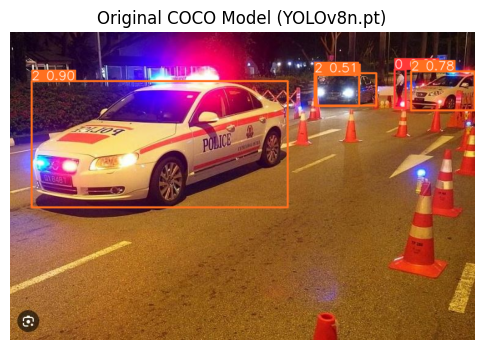

In [60]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(result_coco.plot()[...,::-1])
ax.set_axis_off()
ax.set_title('Original COCO Model (YOLOv8n.pt)')

Text(0.5, 1.0, 'Traffic Cone Model')

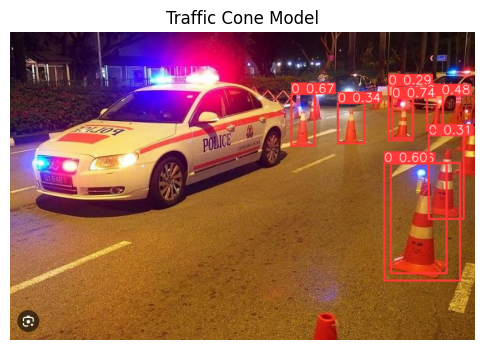

In [54]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(result_cone.plot()[...,::-1])
ax.set_axis_off()
ax.set_title('Traffic Cone Model')

Text(0.5, 1.0, 'Merged Model')

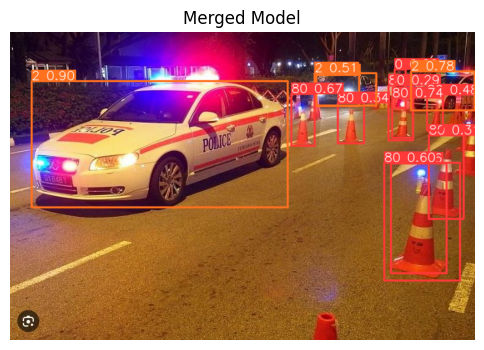

In [53]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(result_merged.plot()[...,::-1])
ax.set_axis_off()
ax.set_title('Merged Model')

We successfully added an extra head specifically for the new class (**traffic cone**) and trained the new head.
The model can detect original COCO classes like cars and persons, as well as a newly trained class, the traffic cones.